# Exploring Test Result Data

In [301]:
import numpy as np              #Provides multidimensional arrays and related capabilities.
import pandas as pd             #Statistics library that adds tables and related capabilities.
import scipy.stats as stats     #Statistic library
import matplotlib.pyplot as plt #2D plotting library that works like MATLAB.
import seaborn as sns           #Visualizations built on top of pyplot.
from IPython.display import display_html 

sns.set(style="darkgrid")
pageWidth = 25

## Summary of Response Time
Outliers removed by filtering out all samples where the elapsed time has an absolute Z score of 3 or higher.
Z score signifies how much standard deviation a sample point has from the mean (average).  
More specifically:  
$\mathbf{Z} = \frac{(X - \mu)}{\sigma}$, where: $X$ = a sample, $\mu$ = the mean, and $\sigma$ = standard deviation

Skew is defined as

In [302]:
# Load the test results file into memory.
samples = pd.read_csv('./results.csv')

# Process the Unix/Epoch Time to make processing easier.
# Convert to my local time zone of CST.
samples['localTime'] = ( pd.to_datetime(samples['timeStamp'],unit='ms') #convert Epoch to Date/Time
                      .dt.tz_localize('UTC')                            # Declare we're using UTC
                      .dt.tz_convert('US/Central'))                     # Convert to my local time.

# Calculate the Z Score of the elapsed time.
# We can use this to filter outliers, if needed.
samples['elapsedTimeZScore'] = stats.zscore(samples.elapsed)

# Create a second data set that filters out the outliers.
#filteredSamples = samples[lambda i: i.elapsed <= THREASHOLD]
filteredSamples = samples[lambda i: np.abs(i.elapsedTimeZScore) < 3]

### Scatter Plot of Response Time

In [303]:
THREASHOLD = 2000

def p90(column):
    return column.quantile(0.9)

def p95(column):
    return column.quantile(0.95)

def p99(column):
    return column.quantile(0.99)

def red_when_higher_than_threshold(val):
    color = 'red' if val >= THREASHOLD else 'white'
    return 'color: %s' % color 

summaryOfOriginal = samples.groupby("responseCode").agg( {'elapsed': ['count','min', 'median', p90, p95, p99, 'max', 'mean', 'skew', 'std']})
styler1 = (summaryOfOriginal.style
    .set_table_attributes("style='display:inline'")
    .set_caption('Full Data Set')
    .applymap(red_when_higher_than_threshold)
    .set_precision(0))

summaryOfFiltered = filteredSamples.groupby("responseCode").agg( {'elapsed': ['count','min', 'median', p90, p95, p99, 'max', 'mean', 'skew', 'std']})
styler2 = (summaryOfFiltered.style
    .set_table_attributes("style='display:inline'")
    .set_caption('Outliers Removed')
    .applymap(red_when_higher_than_threshold)
    .set_precision(0))

# Render the tables side by side
display_html(styler1._repr_html_()+styler2._repr_html_(), raw=True)


Full Data Set elapsed count min median p90 p95 p99 max mean skew std responseCode 
 
 200 
 1000 
 99 
 106 
 142 
 360 
 394 
 3446 
 132 
 18 
 129 
 
 Outliers Removed elapsed count min median p90 p95 p99 max mean skew std responseCode 
 
 200 
 995 
 99 
 106 
 139 
 358 
 383 
 506 
 127 
 3 
 67

### Plot of Response Time
Color is driven by request sucess. 
Size is driven by response time.

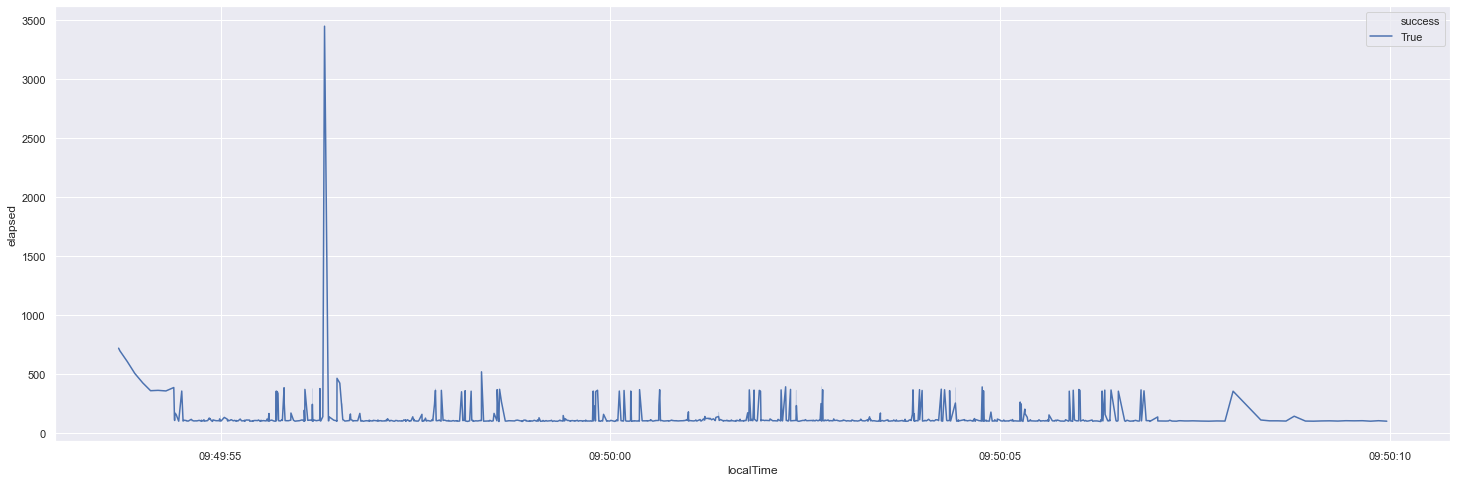

In [304]:
plt.figure(figsize=(pageWidth,8))
sns.lineplot(x="localTime", y="elapsed",
             hue="success", style="success",
             data=samples)

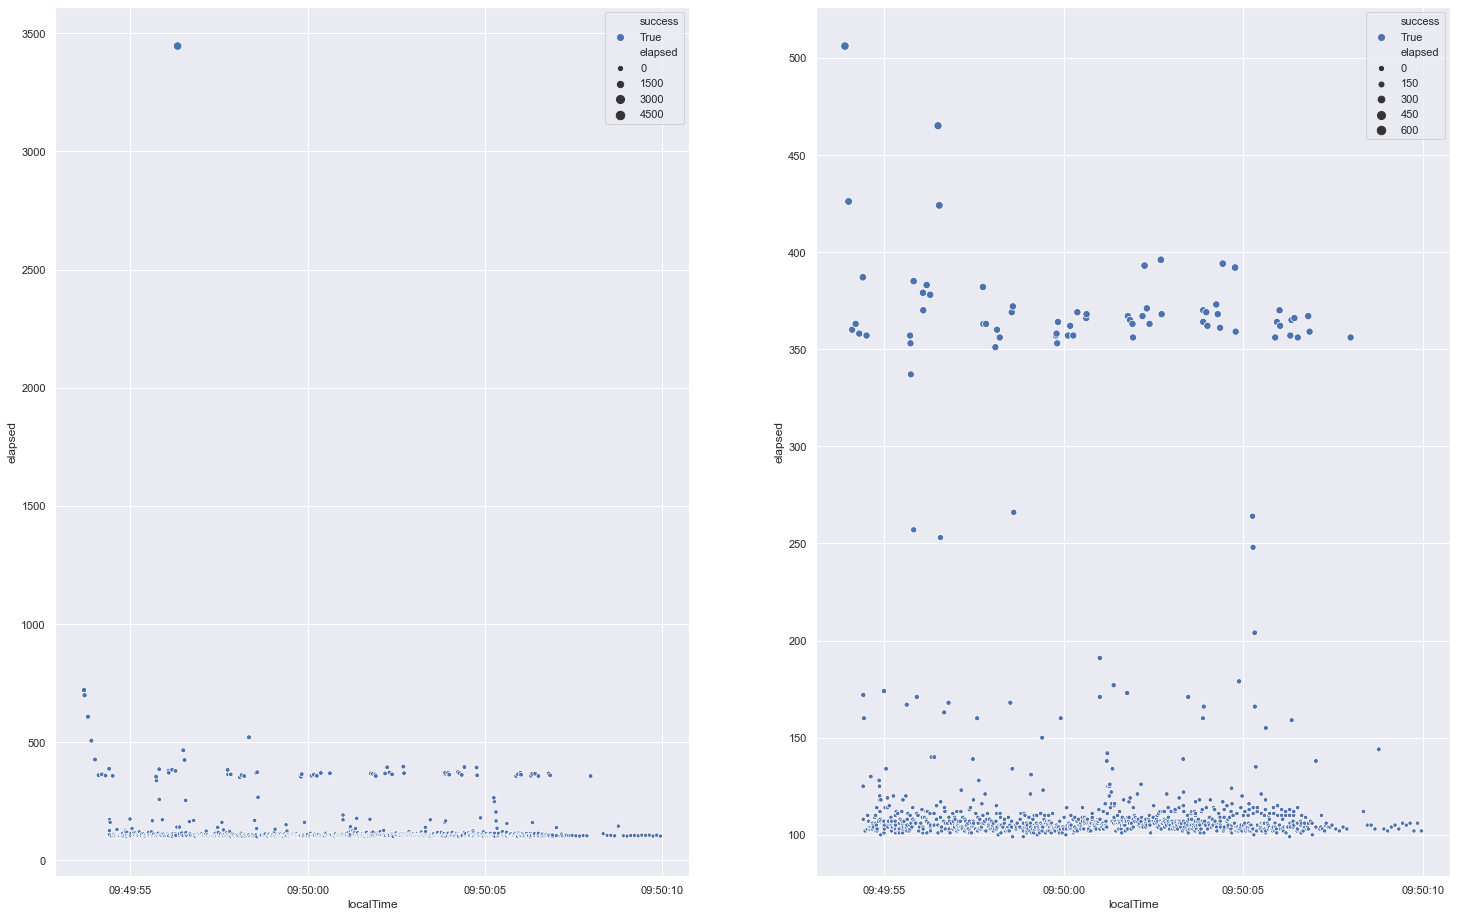

In [305]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(pageWidth,16))
sns.scatterplot(x="localTime", y="elapsed", hue="success", size="elapsed", ax=axes[0], data=samples);
sns.scatterplot(x="localTime", y="elapsed", hue="success", size="elapsed", ax=axes[1], data=filteredSamples)

## The Request's distribution.
A histogram with a kernel density estimate (KDE)

Histogram of the entire sample set minus the outliers.


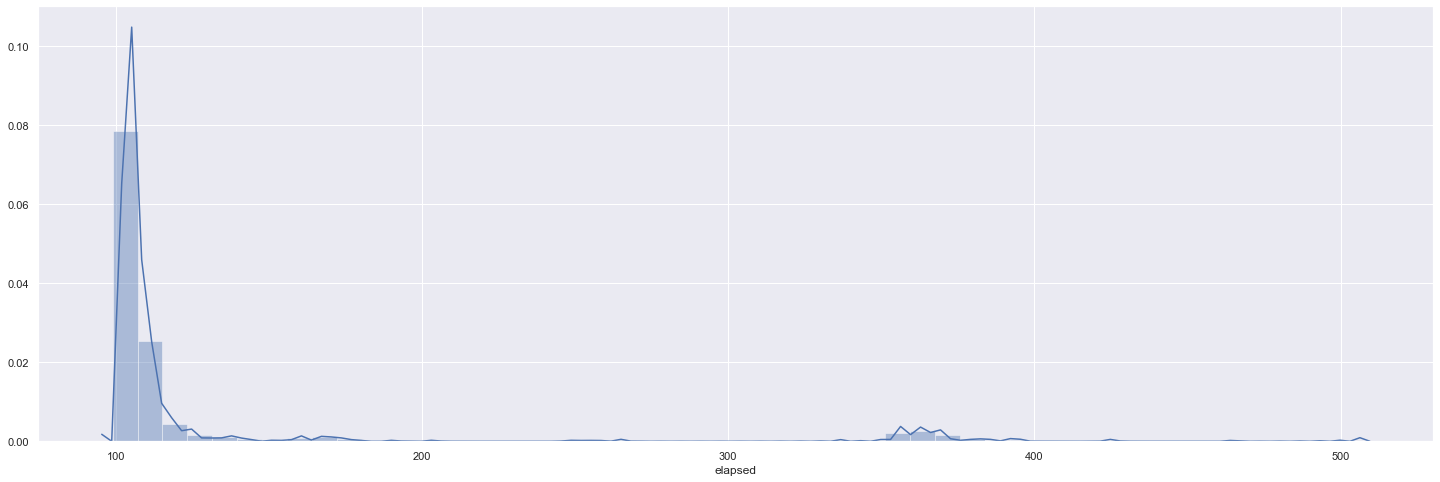

In [306]:
plt.figure(figsize=(pageWidth,8))
# sns.distplot(filteredSamples.elapsed, bins=100, kde=False, norm_hist=True)
print('Histogram of the entire sample set minus the outliers.')
sns.distplot(filteredSamples.elapsed) #Histogram of the entire set minus the outliers.

Two Histograms displaying [100,200] and [300, 400]


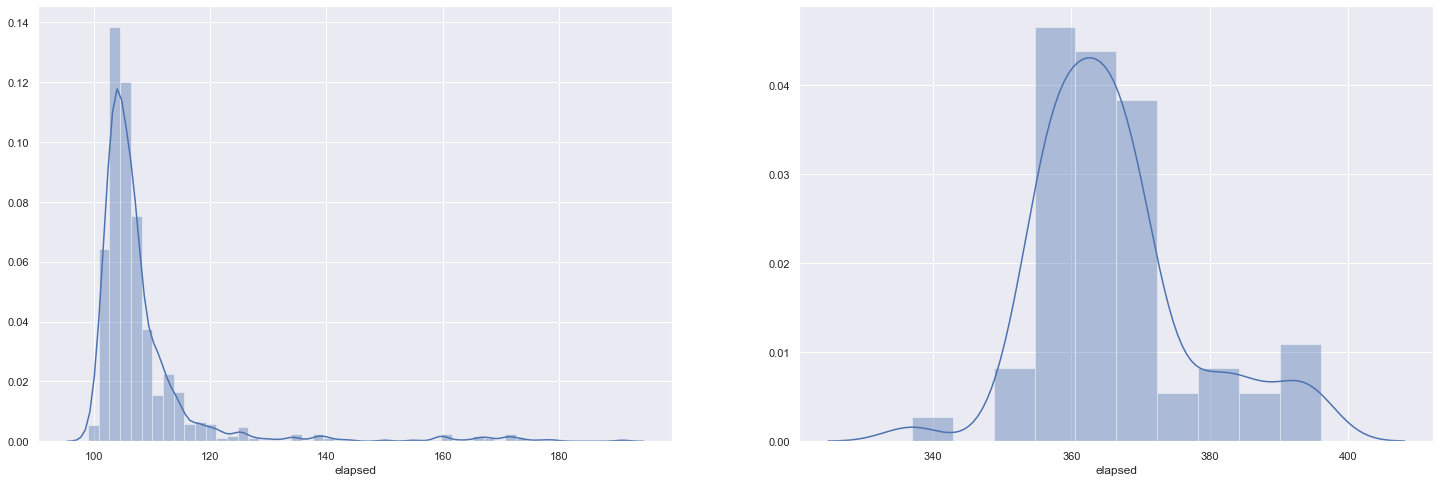

In [307]:
# Just look at the two main groups of requests.
firstRange = lambda i: i.elapsed <= 200
secondRange = lambda i: ((i.elapsed >= 300) & (i.elapsed <= 400))
firstGroup = filteredSamples[firstRange]
secondGroup = filteredSamples[secondRange]
print('Two Histograms displaying [100,200] and [300, 400]')
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(pageWidth,8)) 
sns.distplot(firstGroup.elapsed, ax=axes[0])
sns.distplot(secondGroup.elapsed, ax=axes[1])